DATA SCRAPING FROM LIST.AM

In [ ]:
# Import necessary libraries
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Define the base and category URLs for car listings
base_url = 'https://www.list.am/'
category_url = 'https://www.list.am/category/23'

# Initialize the WebDriver (using Chrome)
driver = webdriver.Chrome()
driver.get(category_url)  # Open the category URL

# Wait for the page to load
driver.implicitly_wait(10)

# Get the HTML content of the page
page_content = driver.page_source

# Use BeautifulSoup to parse the HTML content
soup = BeautifulSoup(page_content, 'html.parser')

# Find all <a> tags with href attribute containing "/item/"
car_links = soup.find_all('a', href=lambda x: x and '/item/' in x)

# Check if any car links are found
if not car_links:
    print("No car links found.")
else:
    # Initialize a list to store car data
    all_car_data = []

    # Iterate through each car link
    for link in car_links:
        # Construct the URL for the individual car page
        individual_car_url = f"{base_url}{link['href']}"

        # Navigate to the individual car page and scrape the data
        driver.get(individual_car_url)

        # Parse the HTML content of the individual car page
        individual_car_page_content = driver.page_source
        individual_car_soup = BeautifulSoup(individual_car_page_content, 'html.parser')

        # Scrape data from the individual car page
        try:
            # Example: Scraping price information
            price_span = individual_car_soup.find('span', class_='price x')
            if price_span:
                price_value = price_span.get('content')

                # Example: Scraping other information
                attr_div = individual_car_soup.find('div', class_='attr g')
                if attr_div:
                    attr_items = attr_div.find_all('div', class_='c')
                    car_data = {'price': price_value}

                    # Iterate through attribute items on the page
                    for item in attr_items:
                        title = item.find('div', class_='t').text.strip()

                        # Map Armenian column names to English
                        column_mapping = {
                            'Մակնիշ': 'brand',
                            'Մոդել': 'model',
                            'Տարի': 'year',
                            'Շարժիչ': 'engine_type',
                            'Շարժիչի ծավալը': 'engine_volume',
                            'Փոխանցման տուփը': 'gearbox'
                        }

                        # Use the English column names and extract values
                        if title in column_mapping:
                            english_title = column_mapping[title]
                            value = item.find('div', class_='i').text.strip()
                            car_data[english_title] = value

                    # Append the car data to the list
                    all_car_data.append(car_data)
        except Exception as e:
            print(f"Failed to scrape data from {individual_car_url}. Error: {str(e)}")

# Close the WebDriver after scraping all pages
driver.quit()

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(all_car_data)

# Save the DataFrame to a CSV file
df.to_csv('car_data.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('car_data.csv')

# Display the DataFrame (commented out for brevity)
# print(df)


LIST.AM DATA CLEANING

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Read the data from the previously scraped and saved CSV file
df = pd.read_csv('car_data.csv')

# Create a new DataFrame for cleaned data, ensuring the original DataFrame remains unchanged
df_cleaned = df.copy()

# Identify and print missing values
print(df_cleaned.isnull().sum())

# Handling missing values using SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')
df_cleaned['price'] = imputer.fit_transform(df_cleaned[['price']])

# Extract the numeric part from 'engine_volume' and convert it to float
df_cleaned['engine_volume_numeric'] = df_cleaned['engine_volume'].str.extract(r'(\d+\.\d+)').astype(float)

# Handle outliers and inconsistencies based on domain knowledge (e.g., removing unrealistic or incorrect prices)
df_cleaned = df_cleaned[df_cleaned['price'] > 0]

# Check for outliers in 'engine_volume_numeric' and handle them using a threshold
engine_volume_threshold = 10  # Adjust this threshold based on your domain knowledge
df_cleaned = df_cleaned[df_cleaned['engine_volume_numeric'] < engine_volume_threshold]

# Select only numeric columns for correlation analysis
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_cleaned[numeric_columns].corr()

# Standardize numerical columns using StandardScaler
scaler = StandardScaler()
df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])

# Example of EDA and Visualization
# Pairplot for numerical features
sns.pairplot(df_cleaned[numeric_columns])
plt.show()

# Correlation matrix heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Save the cleaned DataFrame to a new CSV file
df_cleaned.to_csv('cleaned_car_data.csv', index=False)

# Display the cleaned DataFrame (commented out for brevity)
# print(df_cleaned)


Data Acquisition and Loading

In [ ]:
# Import necessary library
import requests

# URLs for the training and testing datasets
url_train = "https://raw.githubusercontent.com/irvansikajudin/Car-Price-Prediction/main/train_2.csv"
url_test = "https://raw.githubusercontent.com/irvansikajudin/Car-Price-Prediction/main/test.csv"

# Attempt to retrieve and save the training dataset
try:
    # Get the training dataset
    response_train = requests.get(url_train)
    response_train.raise_for_status()  # Check for errors

    # Save the training dataset to a file
    with open("train.csv", "wb") as file:
        file.write(response_train.content)

    print("Training data successfully retrieved and saved as train.csv")

    # Get the testing dataset
    response_test = requests.get(url_test)
    response_test.raise_for_status()  # Check for errors

    # Save the testing dataset to a file
    with open("test.csv", "wb") as file:
        file.write(response_test.content)

    print("Testing data successfully retrieved and saved as test.csv")

except requests.exceptions.RequestException as e:
    print(f"Error retrieving data: {e}")


Training data successfully retrieved and saved as train.csv
Testing data successfully retrieved and saved as test.csv


Data Loading and Initial Exploration

In [ ]:
# Import necessary library
import pandas as pd

# File paths for the training and testing datasets
file_path_train = "train.csv"

# Read the training dataset into a DataFrame
df_train = pd.read_csv(file_path_train)

# Select specific columns of interest for analysis
selected_columns = ["Price", "Manufacturer", "Model", "Prod. year", "Fuel type", "Engine volume", "Mileage", "Gear box type", "Leather interior", "Cylinders", "Color"]
df_train = df_train[selected_columns]

# File path for the testing dataset (Note: The file path is the same as the training dataset in the provided code)
file_path_test = "train.csv"

# Read the testing dataset into a DataFrame
df_test = pd.read_csv(file_path_test)

# Select the same columns for testing dataset as for training dataset
df_test = df_test[selected_columns]

# Display the first 10 rows of the testing dataset
print(df_test.head(10))



   Price Manufacturer     Model  Prod. year Fuel type Engine volume  \
0  13328        LEXUS    RX 450        2010    Hybrid           3.5   
1  16621    CHEVROLET   Equinox        2011    Petrol             3   
2   8467        HONDA       FIT        2006    Petrol           1.3   
3   3607         FORD    Escape        2011    Hybrid           2.5   
4  11726        HONDA       FIT        2014    Petrol           1.3   
5  39493      HYUNDAI  Santa FE        2016    Diesel             2   
6   1803       TOYOTA     Prius        2010    Hybrid           1.8   
7    549      HYUNDAI    Sonata        2013    Petrol           2.4   
8   1098       TOYOTA     Camry        2014    Hybrid           2.5   
9  26657        LEXUS    RX 350        2007    Petrol           3.5   

     Mileage Gear box type Leather interior  Cylinders   Color  
0  186005 km     Automatic              Yes        6.0  Silver  
1  192000 km     Tiptronic               No        6.0   Black  
2  200000 km      Varia

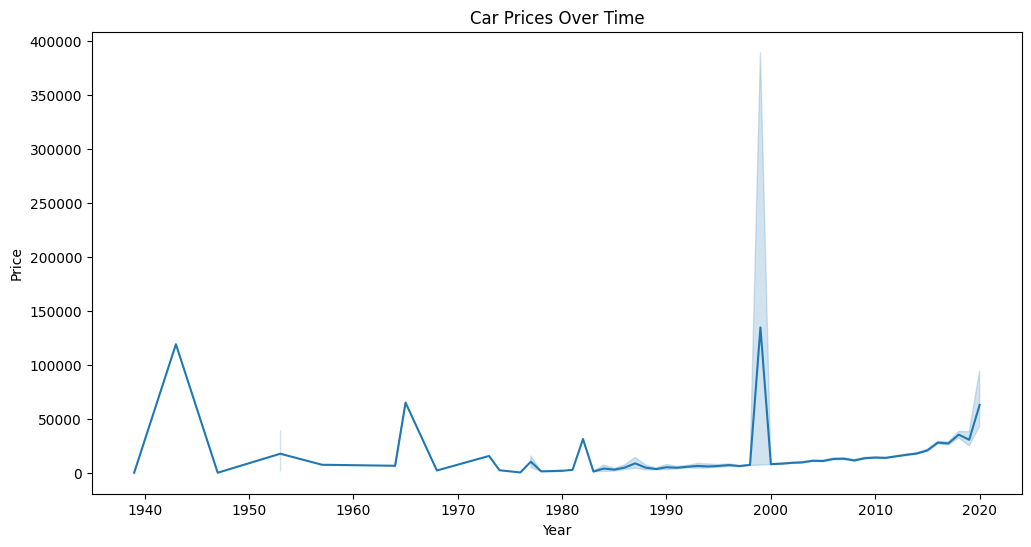

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Prod. year', y='Price', data=df_train)
plt.title('Car Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()


Data Cleaning and Preprocessing

In [ ]:
# Import necessary libraries
import pandas as pd
import re

# Handle missing values by dropping rows with missing values
df_cleaned_train = df_train.dropna()
df_cleaned_test = df_test.dropna()

# Extract numeric part from "Engine volume" and convert to numeric for both training and testing datasets
df_cleaned_train["Engine volume"] = df_cleaned_train['Engine volume'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x))).astype(float)
df_cleaned_train["Cylinders"] = df_cleaned_train['Cylinders'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x))).astype(float)
df_cleaned_train['Mileage'] = df_cleaned_train['Mileage'].apply(lambda x: re.search(r'\d+', str(x)).group() if re.search(r'\d+', str(x)) else None)

df_cleaned_test["Engine volume"] = df_cleaned_test['Engine volume'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x))).astype(float)
df_cleaned_test["Cylinders"] = df_cleaned_test['Cylinders'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x))).astype(float)
df_cleaned_test['Mileage'] = df_cleaned_test['Mileage'].apply(lambda x: re.search(r'\d+', str(x)).group() if re.search(r'\d+', str(x)) else None)

# Encode categorical variables using one-hot encoding for both training and testing datasets
df_cleaned_train = pd.get_dummies(df_cleaned_train, columns=['Manufacturer', 'Model', 'Fuel type', 'Gear box type', 'Leather interior', 'Color'])
df_cleaned_test = pd.get_dummies(df_cleaned_test, columns=['Manufacturer', 'Model', 'Fuel type', 'Gear box type', 'Leather interior', 'Color'])

# Save the cleaned data to CSV without scaling the target variable
output_file_path_train = "cleaned_data_train.csv"
output_file_path_test = "cleaned_data_test.csv"
df_cleaned_train.to_csv(output_file_path_train, index=False)
print(f"Train Cleaned data saved to {output_file_path_train}")
df_cleaned_test.to_csv(output_file_path_test, index=False)
print(f"Test Cleaned data saved to {output_file_path_test}")


Train Cleaned data saved to cleaned_data_train.csv
Test Cleaned data saved to cleaned_data_test.csv


Decision Tree Regressor Model Training and Evaluation

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import export_text
import seaborn as sns
from sklearn.tree import plot_tree

# Load your cleaned and preprocessed dataset
df_train = pd.read_csv("cleaned_data_train.csv")
df_test = pd.read_csv("cleaned_data_test.csv")

# Assume 'Price' is the target variable
X_train = df_train.drop("Price", axis=1)
y_train = df_train["Price"]
X_test = df_test.drop("Price", axis=1)
y_test = df_test["Price"]

# Create a Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 246.2088348571324
Mean Squared Error: 4061305.135067482
R-squared: 0.9998881778688634


Visualization

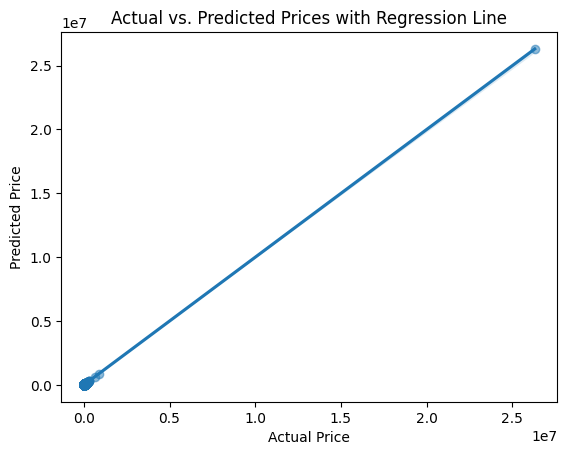

In [ ]:
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices with Regression Line")
plt.show()


Random Forest Regressor Model Training and Evaluation

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Create a Random Forest Regressor model with a fixed random seed for reproducibility
model = RandomForestRegressor(random_state=42)

# Train the Random Forest model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance using common regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Mean Absolute Error: 3111.383958062793
Mean Squared Error: 8912853536.27328
R-squared: 0.7545975385280281


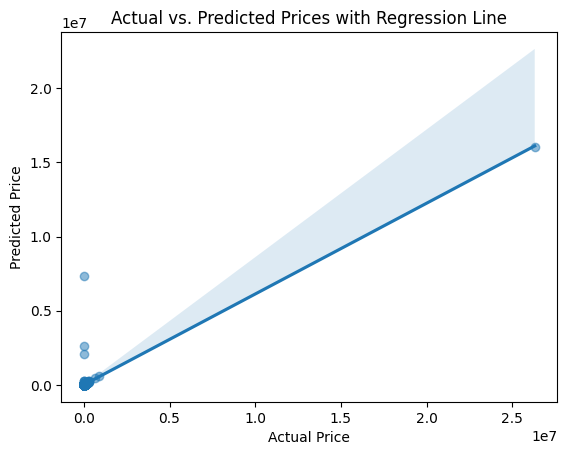

In [ ]:
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices with Regression Line")
plt.show()


Voting Regressor Model

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Create individual models
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

# Create a Voting Regressor model combining both individual models
voting_regressor_model = VotingRegressor(estimators=[('decision_tree', decision_tree_model), ('random_forest', random_forest_model)])

# Train the Voting Regressor model on the training data
voting_regressor_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = voting_regressor_model.predict(X_test)

# Evaluate the model performance using common regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Mean Absolute Error: 1678.2576462186125
Mean Squared Error: 2231259362.91962
R-squared: 0.9385655180336546


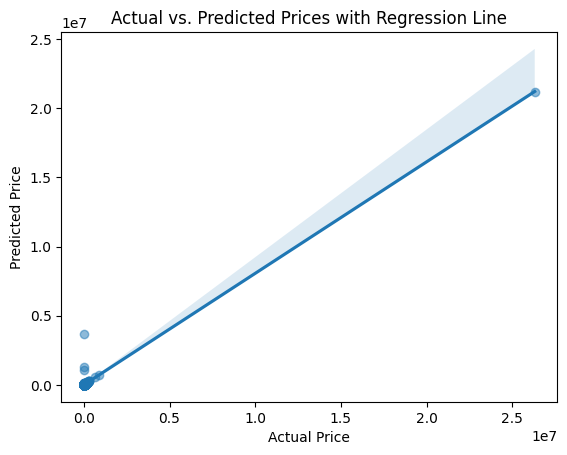

In [ ]:
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices with Regression Line")
plt.show()
